In [1]:
import numpy as np
print("Numpy version: "+np.__version__)

import somoclu
print("Somoclu version: "+somoclu.__version)
from PIL import Image
%matplotlib inline
import matplotlib.pylab as plt
print("Matplotlib version: "+plt.__version__)
from mpl_toolkits.mplot3d import Axes3D

Numpy version: 1.13.0
Somoclu version: 1.7.4
Matplotlib version: 1.13.0


## Generating a random image

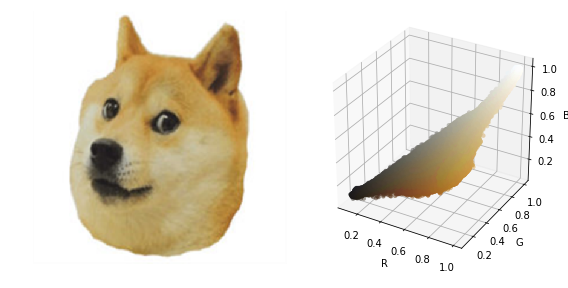

In [2]:
fig = plt.figure(figsize=(8, 4))

img = Image.open("data/doge.png")
img = np.array(img.getdata(), np.uint8)/255.0
Npix = int(np.sqrt(img.shape[0]))

#Npix = 50
#img = np.random.randint(low=0, high=2, size=(Npix*Npix, 3))  + 0.1*np.random.randn(Npix*Npix, 3)
#img[img > 1.0] = 1.0
#img[img < 0.0] = 0.0
ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(img, (Npix, Npix, 4)))
#ax.imshow(img)
ax.axis('off')
ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.scatter(img[:, 0], img[:, 1], img[:, 2], c=img, linewidth=0, s=20)
ax.set_xlabel('R')
ax.set_ylabel('G')
ax.set_zlabel('B')
fig.tight_layout()

## Training the Self-organizing map

In [3]:
%%time
N_samples = img.shape[0]
N_neurons = 10
som_dim = np.ceil([1.2*np.sqrt(N_neurons), np.sqrt(N_neurons)/1.2])
print("%d datos" %(N_samples))
print("%d prototipos" %(som_dim[0]*som_dim[1]))
print(som_dim)
som = somoclu.Somoclu(int(som_dim[0]), int(som_dim[1]), data=img[:, :3], 
                      maptype='planar', gridtype="rectangular", initialization='random')

som.train(epochs=10*int(som_dim[0]*som_dim[1]), scale0=0.5, scaleN=0.05, scalecooling='linear',
          radius0=int(np.amax(som_dim)/2), radiusN=int(np.amax(som_dim)/16), radiuscooling='linear')
som.train(epochs=10*int(som_dim[0]*som_dim[1]), scale0=0.05, scaleN=0.0, scalecooling='linear',
          radius0=int(np.amax(som_dim)/16), radiusN=1, radiuscooling='linear')

176400 datos
12 prototipos
[ 4.  3.]
CPU times: user 21.5 s, sys: 22.9 ms, total: 21.5 s
Wall time: 7.55 s


In [4]:
""" 
Quantization error: Average distance between data and their BMU
"""
qe = 0.0
for i in range(N_samples):
    qe += np.linalg.norm(img[i, :3] - som.codebook[som.bmus[i][1],som.bmus[i][0], :])
print("Quantization error: %f" %(qe/N_samples))

"""
Topographic error: the proportion of all data vectors for 
which first and second BMUs are not adjacent units. 
Measures topology preservation.
"""
te = 0.0

Quantization error: 0.031265


## Visualizing the prototype vectors

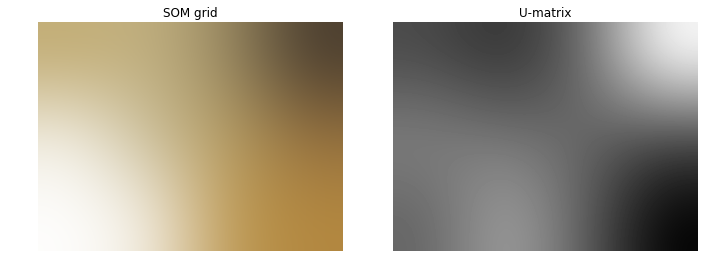

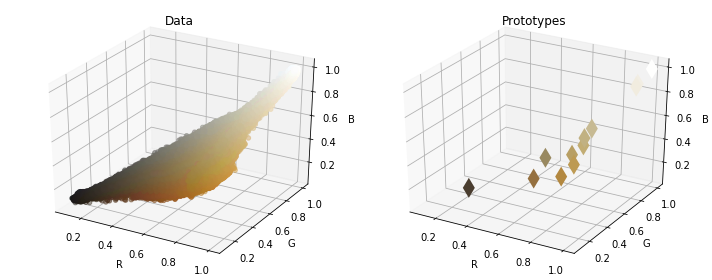

In [5]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 2, 1)
ax.imshow(som.codebook, interpolation='bicubic')
ax.axis('off')
ax.set_title('SOM grid')
ax = fig.add_subplot(1, 2, 2)
ax.imshow(som.umatrix, cmap='gray', interpolation='bicubic')
ax.axis('off')
ax.set_title('U-matrix')
fig.tight_layout()

fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.scatter(img[:, 0], img[:, 1], img[:, 2], c=img, linewidth=1, s=20)
ax.set_xlabel('R')
ax.set_ylabel('G')
ax.set_zlabel('B')
ax.set_title('Data')
xlim, ylim, zlim = ax.get_xlim(), ax.get_ylim(), ax.get_zlim()

ax = fig.add_subplot(1, 2, 2, projection='3d')
M = np.reshape(som.codebook, (int(som_dim[0]*som_dim[1]), 3))
ax.scatter(M[:, 0], M[:, 1], M[:, 2], c=M, marker='d', linewidth=0, s=200, alpha=1.0)
ax.set_xlabel('R')
ax.set_ylabel('G')
ax.set_zlabel('B')
ax.set_title('Prototypes')
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_zlim(zlim)
fig.tight_layout()

## Prototypes over the U-matrix

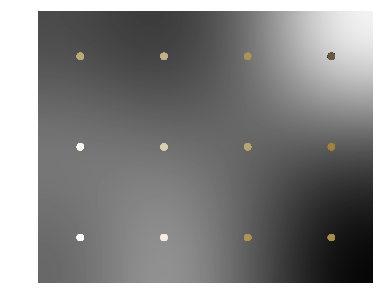

In [6]:
_ = som.view_umatrix(figsize=(6, 5), bestmatches=True, bestmatchcolors=img, 
                     colorbar=False, colormap='gray')

## Visualizing the individual componets (RGB)

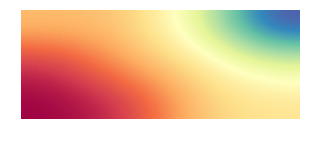

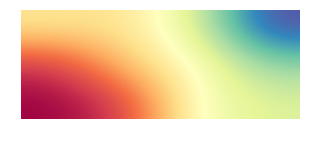

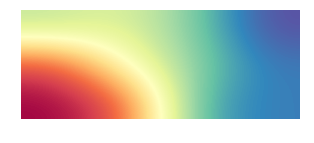

In [7]:
_ = som.view_component_planes(figsize=(5, 2))

## Reconstructed image

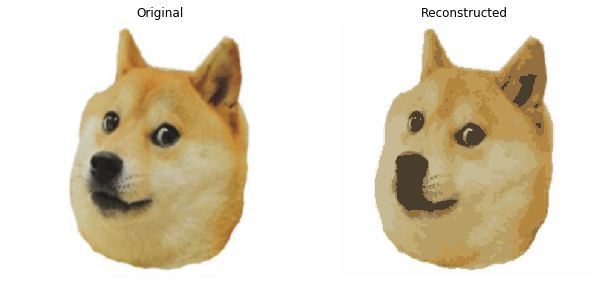

In [8]:
compressed_img = np.zeros(shape=(Npix*Npix, 3))
for i in range(Npix*Npix):
    compressed_img[i, :] = som.codebook[som.bmus[i, 1], som.bmus[i, 0], :]

fig = plt.figure(figsize=(10, 6))

ax = fig.add_subplot(1, 2, 1)
_ = ax.imshow(np.reshape(img, (Npix, Npix, 4)))
_ = ax.axis('off')
_ = plt.title('Original')
ax = fig.add_subplot(1, 2, 2)
_ = ax.imshow(np.reshape(compressed_img, (Npix, Npix, 3)))
_ = ax.axis('off')
_ = plt.title('Reconstructed')